## **Mini project Kelas 1 Geosoftware**
# Analisis dan Klasifikasi Risiko Sosial Ekonomi Desa Menggunakan Decision Tree

**Tujuan**

Mengelompokkan desa-desa berdasarkan karakteristik sosial ekonomi (seperti tingkat pendidikan,
umur produktif dan pengangguran), dan kemudian membangun model prediktif untuk
mengklasifikasikan desa ke dalam kategori risiko sosial ekonomi (Low, Medium, High).



In [ ]:
# Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
# Buka file dan ganti koordinat sistem
file = gpd.read_file ('/content/processed_jkt.shp')
file = file.to_crs(epsg=32748)
file.head()
file.columns

Index(['OBJECT_ID', 'KODE_DESA', 'DESA', 'KODE', 'PROVINSI', 'KAB_KOTA',
       'KECAMATAN', 'DESA_KELUR', 'JUMLAH_PEN', 'JUMLAH_KK', 'LUAS_WILAY',
       'KEPADATAN', 'PERPINDAHA', 'PERUBAHAN', 'WAJIB_KTP', 'ISLAM', 'KRISTEN',
       'KHATOLIK', 'HINDU', 'BUDHA', 'KONGHUCU', 'KEPERCAYAA', 'PRIA',
       'WANITA', 'BELUM_KAWI', 'KAWIN', 'BELUM_BEKE', 'GENERATED',
       'KODE_DES_1', 'LUAS_DESA', 'KODE_DES_3', 'DESA_KEL_1', 'KODE_12',
       'BEKERJA', 'USIA_PRODU', 'USIA_NON_P', 'P_RENDAH', 'P_TINGGI',
       'resiko_kre', 'luas_km2', 'keliling_k', 'kompaksi', 'jarak_ke_m',
       'kepadata_1', 'rasio_prod', 'rasio_pend', 'rasio_peng', 'resiko_k_1',
       'geometry'],
      dtype='object')

In [154]:
# Cek tipe data dan missing values
print(file.info())
print(file.isna().sum())
print(file.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECT_ID   267 non-null    float64 
 1   KODE_DESA   267 non-null    object  
 2   DESA        267 non-null    object  
 3   KODE        267 non-null    float64 
 4   PROVINSI    267 non-null    object  
 5   KAB_KOTA    267 non-null    object  
 6   KECAMATAN   267 non-null    object  
 7   DESA_KELUR  267 non-null    object  
 8   JUMLAH_PEN  267 non-null    float64 
 9   JUMLAH_KK   267 non-null    float64 
 10  LUAS_WILAY  267 non-null    float64 
 11  KEPADATAN   267 non-null    float64 
 12  PERPINDAHA  267 non-null    float64 
 13  PERUBAHAN   267 non-null    float64 
 14  WAJIB_KTP   267 non-null    float64 
 15  ISLAM       267 non-null    float64 
 16  KRISTEN     267 non-null    float64 
 17  KHATOLIK    267 non-null    float64 
 18  HINDU       267 non-null    float64 
 19  

Awalnya ingin melihat bentuk peta dari shapefile, ternyata datanya termasuk pulau2 kecil di sekitar DKI Jakarta yang mana akan saya hilangkan. Saya hanya akan fokus ke pulau besar di DKI Jakarta.

<Axes: >

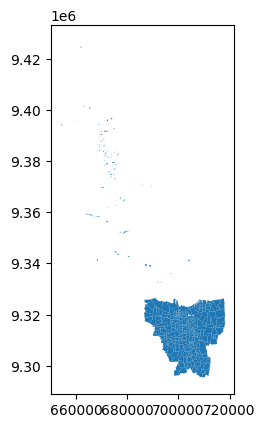

In [155]:
file.plot()

Saya melakukan filter berdasarkan koordinat, saya sudah mecoba menfilter dengan menggunakan kolom namun belum berhasil.

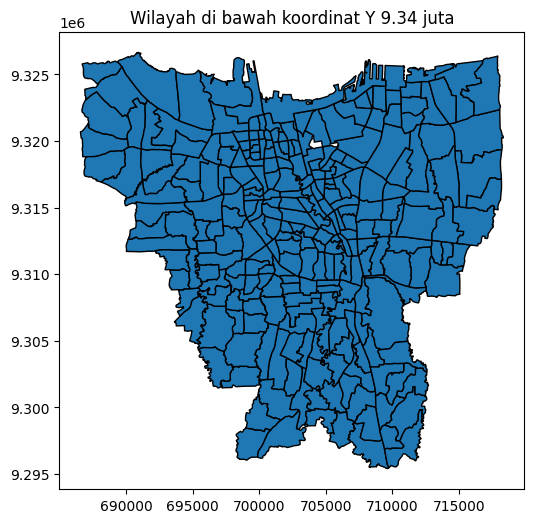

In [158]:
# Fokus hanya di Daerah DKI Jakarta saja, mengecualikan pulau-pulau kecil.

file_filtered = file[file.geometry.centroid.y < 9.33e6]

# Plot hasil filter
file_filtered.plot(figsize=(6, 8), edgecolor='black')
plt.title("Wilayah di bawah koordinat Y 9.33 juta")
plt.show()

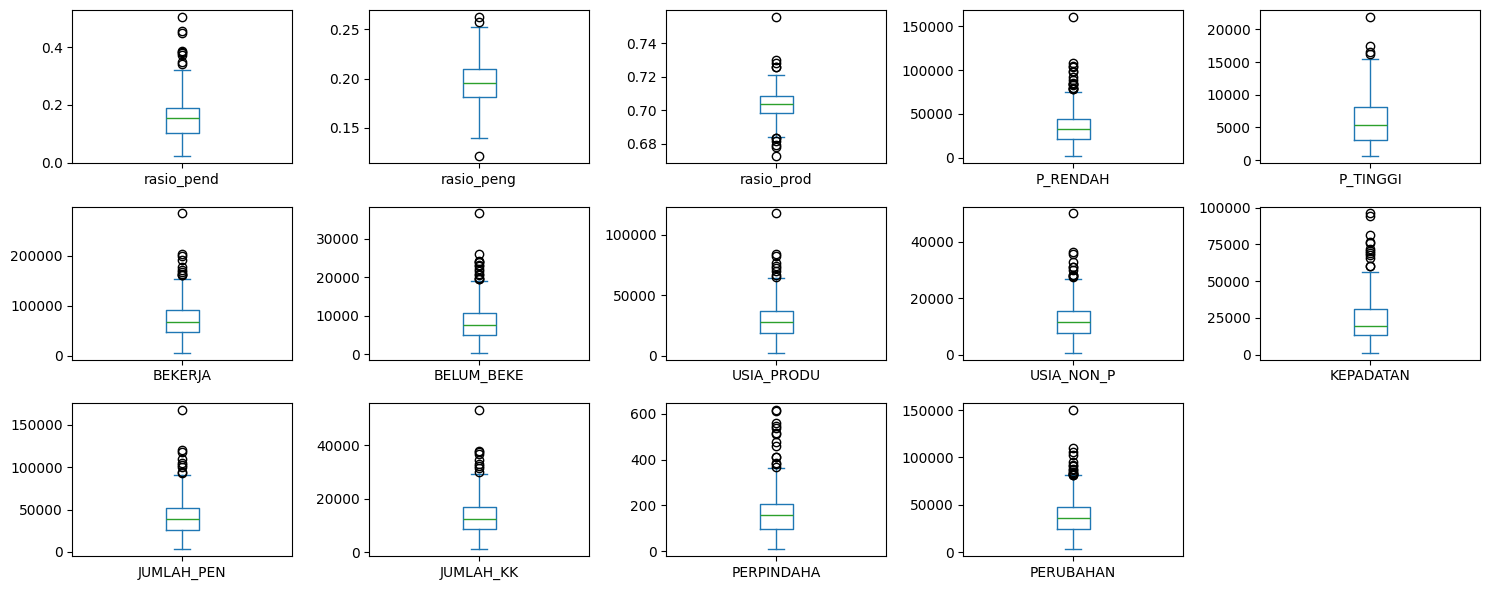


---------------------------------------------------------------------------------------------------------------------------------------------




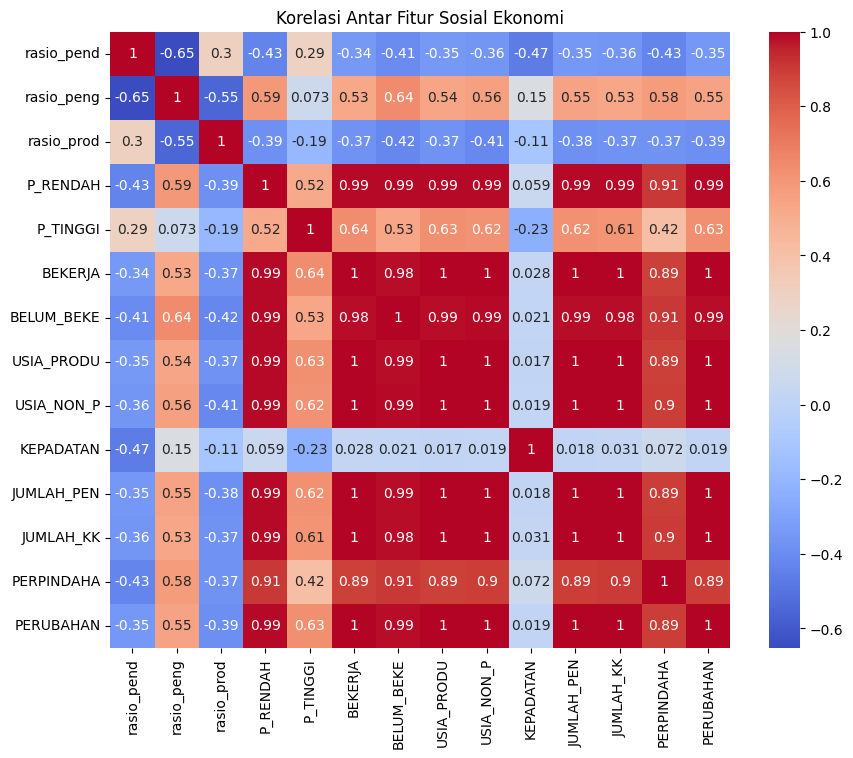

In [177]:
# Visualisasi distribusi fitur
numeric_cols = [
    'rasio_pend', 'rasio_peng', 'rasio_prod',
    'P_RENDAH', 'P_TINGGI',
    'BEKERJA', 'BELUM_BEKE',
    'USIA_PRODU', 'USIA_NON_P',
    'KEPADATAN', 'JUMLAH_PEN', 'JUMLAH_KK',
    'PERPINDAHA', 'PERUBAHAN'
]

# Boxplot semua fitur numerik
file_filtered[numeric_cols].plot(kind='box', figsize=(15, 6), subplots=True, layout=(3, 5), sharex=False)
plt.tight_layout()
plt.show()

print()
print ('---------------------------------------------------------------------------------------------------------------------------------------------')
print()
print()

# Heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(file_filtered[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi Antar Fitur Sosial Ekonomi")
plt.show()

**Hasil dari Bloxplot**

*   Hampir semua fitur memiliki outlier, namun ini tidak menjadi masalah besar untuk Decision Tree karena model ini tidak sensitif terhadap outlier.
Beberapa fitur seperti rasio_peng, rasio_pend, rasio_prod memiliki skala yang relatif konsisten (rasio 0–1), bagus untuk digunakan.
Fitur seperti JUMLAH_PEN, JUMLAH_KK, BEKERJA sangat besar nilainya, dan sangat berkorelasi satu sama lain.

**Hasil dari Heatmap**

*   Korelasi sangat tinggi antara:
P_RENDAH, P_TINGGI, BEKERJA, BELUM_BEKE, USIA_PRODU, USIA_NON_P, JUMLAH_PEN, JUMLAH_KK, PERUBAHAN (semua > 0.99). Hal ini menunjukkan redundansi.

* Rasio_pend vs rasio_peng: korelasi negatif −0.64. Artinya makin tinggi pendidikan, makin rendah pengangguran.

* kepadata_1 dan PERPINDAHA: korelasi rendah/moderat. Artinya bisa memberikan informasi unik.






In [160]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pisahkan fitur dengan target
features = [
    'rasio_pend',       # rasio pendidikan
    'rasio_peng',       # rasio pengangguran
    'rasio_prod',       # rasio usia produktif
    'kepadata_1',       # kepadatan penduduk
    'PERPINDAHA',       # mobilitas penduduk
    'BELUM_BEKE',       # pengangguran yang belum bekerja
]
target = 'resiko_k_1'

In [162]:
# Buang baris dengan missing values (jika ada)
file = file_filtered.dropna(subset=features + [target])

# Tentukan X dan y
X = file[features]
y = file[target]

In [163]:
# Pisahkan data Xtrain dan ytrain kemudian normalisasi
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.8, stratify=y)

# Normalisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [164]:
# Modeling data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Melatih model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Melakukan prediksi
y_pred = model.predict(X_test_scaled)


In [165]:
# Evaluasi model
print("Akurasi:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Akurasi: 0.8325358851674641
[[41  6  1]
 [ 2 38 17]
 [ 0  9 95]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        48
           1       0.72      0.67      0.69        57
           2       0.84      0.91      0.88       104

    accuracy                           0.83       209
   macro avg       0.84      0.81      0.82       209
weighted avg       0.83      0.83      0.83       209



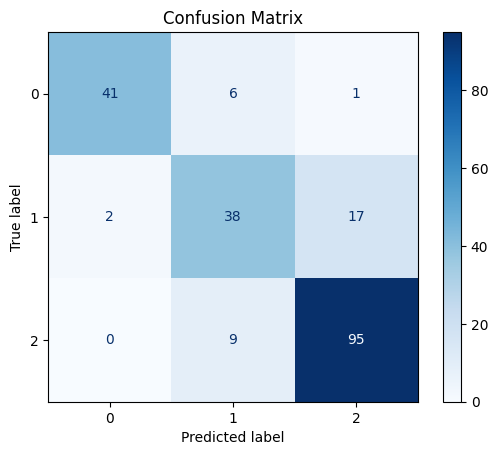

In [166]:
# Grafik confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Model yang saya bangun memiliki nilai Akurasi = 83.25% yang artinya, model mampu mengklasifikasikan 83 dari 100 desa dengan benar ke dalam kategori risiko sosial ekonomi (rendah, sedang, tinggi).

Sedangkan dari hasil Confusion Matrix
* Kelas 0 (Rendah):
41 dari 48 desa diklasifikasikan dengan benar.
6 salah dikira Medium, 1 salah dikira Tinggi.
* Kelas 1 (Sedang):
Agak bermasalah: hanya 38 dari 57 diklasifikasi benar.
17 salah dikira Tinggi → berarti kelas 1 sering dikira kelas 2.
* Kelas 2 (Tinggi):
Performa sangat baik: 95 dari 104 diklasifikasikan benar.
Hanya sedikit yang salah dikira kelas 1 (9 desa).

Secara keseluruhan Model sangat bagus untuk deteksi risiko rendah (0) namun tidak cukup baik untuk mendeteksi resiko sedang, sering tertukar dengan kelas tinggi. Dan juga model bagus mengenali desa berisiko tinggi

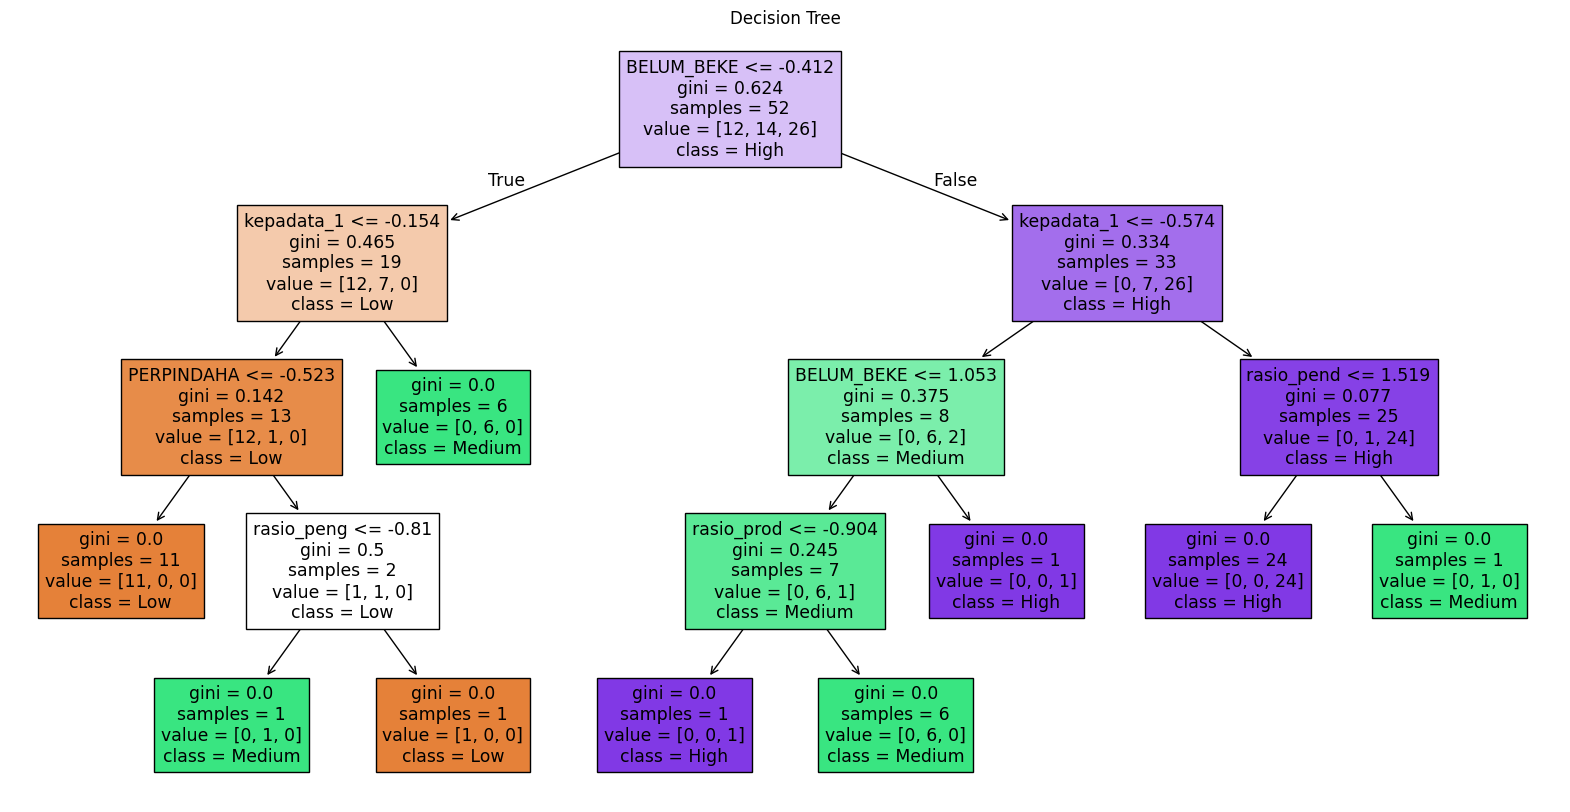

In [167]:
# Feature Importance
from sklearn.tree import plot_tree
# Visualisasi
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns,
class_names=['Low', 'Medium', 'High'], filled=True)
plt.title("Decision Tree")
plt.show()

In [186]:
# Menggabungkan hasil prediksi dalam satu dataframe
file_filtered ['Risiko_k1_pred'] = None
file_filtered.loc[file_filtered.index.isin(X_test.index), 'Risiko_k1_pred'] = y_pred
file_filtered.head()

,OBJECT_ID,KODE_DESA,DESA,KODE,PROVINSI,KAB_KOTA,KECAMATAN,DESA_KELUR,JUMLAH_PEN,JUMLAH_KK,...,jarak_ke_m,kepadata_1,rasio_prod,rasio_pend,rasio_peng,resiko_k_1,geometry,Risiko_k1_pred,Risiko_k1_pred_label,color
0,25477.0,3173031006,KEAGUNGAN,317303.0,DKI JAKARTA,JAKARTA BARAT,TAMAN SARI,KEAGUNGAN,21609.0,7255.0,...,3.039610,61189.911080,0.706604,0.084733,0.181730,1,"POLYGON ((700996.989 9320062.881, 701010.095 9...",0,Rendah,#2E8B57
1,25478.0,3173031007,GLODOK,317303.0,DKI JAKARTA,JAKARTA BARAT,TAMAN SARI,GLODOK,9069.0,3273.0,...,3.703862,24804.913958,0.692689,0.174771,0.153049,0,"POLYGON ((700826.428 9320688.895, 700832.458 9...",0,Rendah,#2E8B57
2,25397.0,3171031003,HARAPAN MULIA,317103.0,DKI JAKARTA,JAKARTA PUSAT,KEMAYORAN,HARAPAN MULIA,29085.0,9217.0,...,3.212556,55083.883622,0.701117,0.132543,0.183428,2,"POLYGON ((705543.36 9317220.295, 705544.961 93...",2,Tinggi,#D62728
3,25400.0,3171031006,CEMPAKA BARU,317103.0,DKI JAKARTA,JAKARTA PUSAT,KEMAYORAN,CEMPAKA BARU,41913.0,13766.0,...,4.014493,43481.014371,0.700451,0.153031,0.193377,2,"POLYGON ((706164.28 9318289.211, 706174.68 931...",2,Tinggi,#D62728
6,25390.0,3171021001,PASAR BARU,317102.0,DKI JAKARTA,JAKARTA PUSAT,SAWAH BESAR,PASAR BARU,15793.0,5599.0,...,1.301816,9073.463830,0.707149,0.189704,0.169442,0,"POLYGON ((703261.214 9318919.285, 703283.365 9...",1,Sedang,#FFEB84


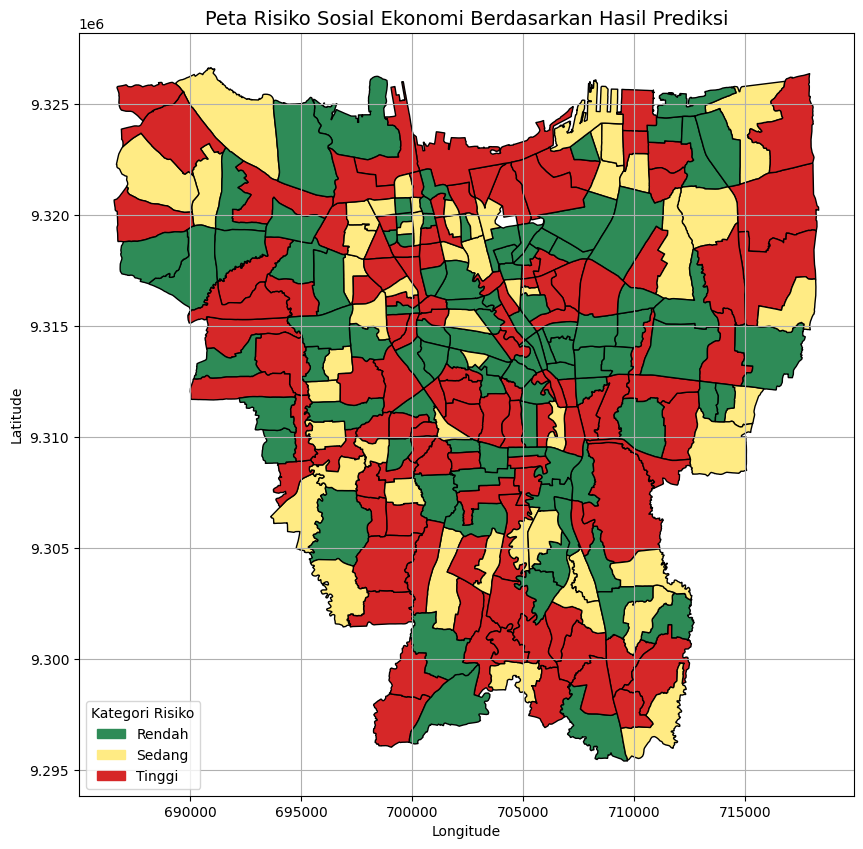

In [188]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. Ganti nilai NaN dengan 0 (Low risk)
file_filtered['Risiko_k1_pred'] = file_filtered['Risiko_k1_pred'].fillna(0)

# 2. Mapping label numerik ke label string
label_map = {0: 'Rendah', 1: 'Sedang', 2: 'Tinggi'}
file_filtered['Risiko_k1_pred_label'] = file_filtered['Risiko_k1_pred'].map(label_map)

# 3. Mapping warna manual
color_dict = {'Rendah': '#2E8B57', 'Sedang': '#FFEB84', 'Tinggi': '#D62728'}
file_filtered['color'] = file_filtered['Risiko_k1_pred_label'].map(color_dict)

# 4. Plot peta
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
file_filtered.plot(color=file_filtered['color'], edgecolor='black', ax=ax)

# 5. Tambahkan grid lat/lon
ax.set_title('Peta Risiko Sosial Ekonomi Berdasarkan Hasil Prediksi', fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# 6. Tambahkan legend manual
legend_patches = [
    mpatches.Patch(color='#2E8B57', label='Rendah'),
    mpatches.Patch(color='#FFEB84', label='Sedang'),
    mpatches.Patch(color='#D62728', label='Tinggi')
]
ax.legend(handles=legend_patches, title='Kategori Risiko', loc='lower left')

plt.show()


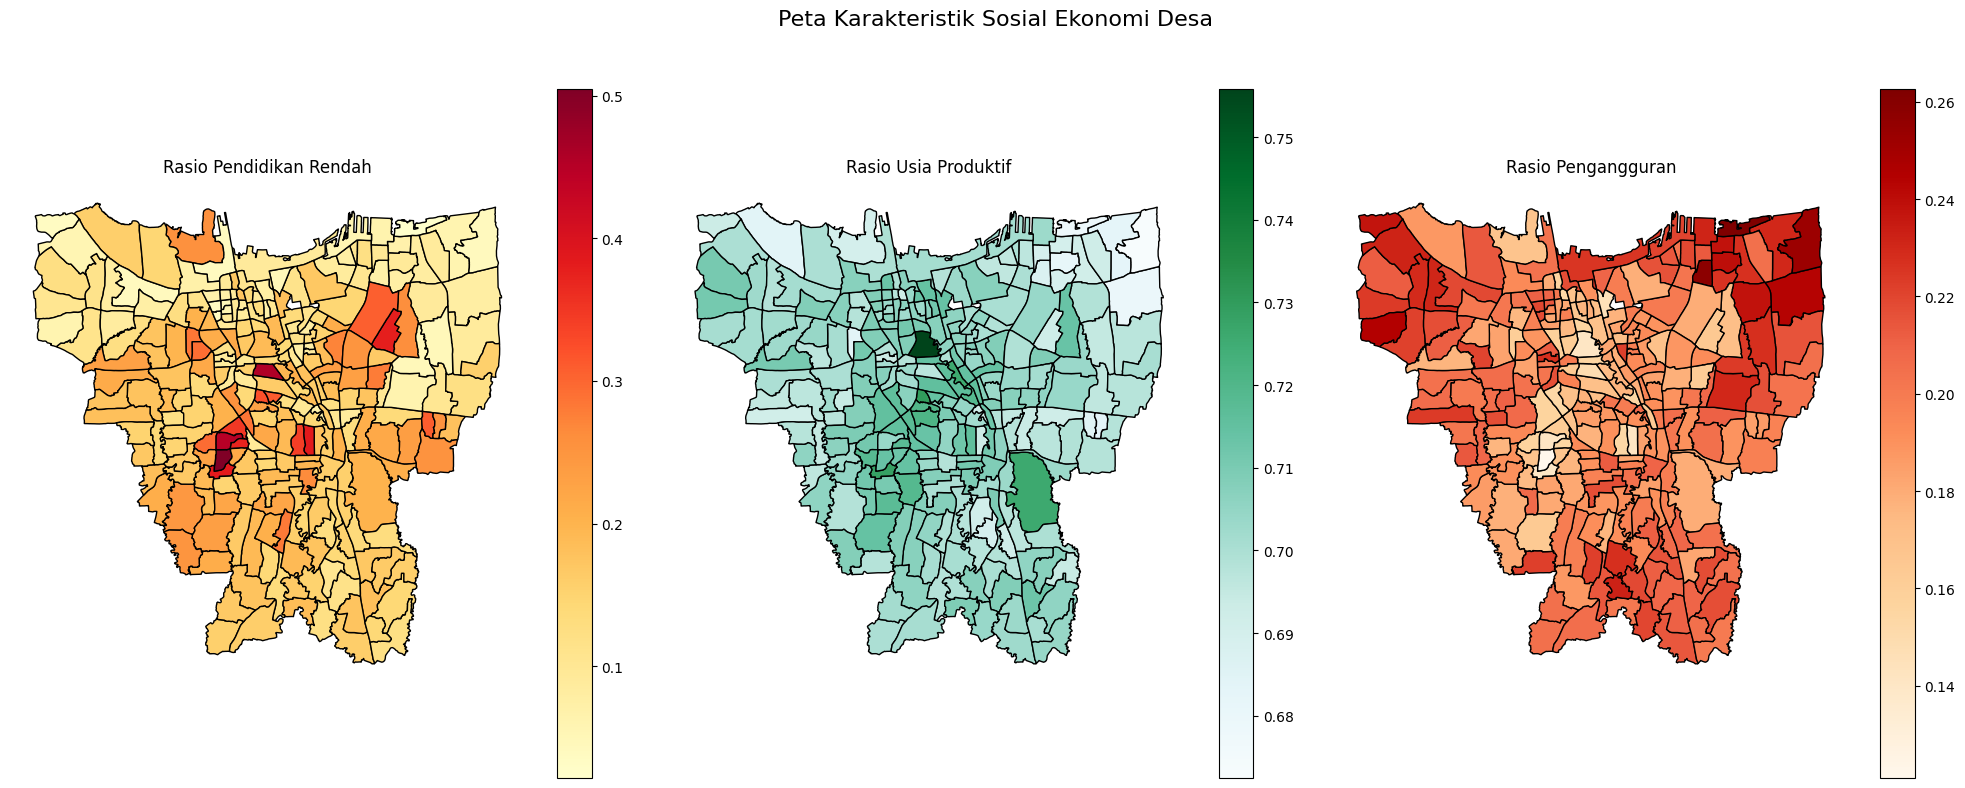

In [179]:

# Setup figure
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# 1. Peta Rasio Pendidikan
file_filtered.plot(
    column='rasio_pend',
    cmap='YlOrRd',
    legend=True,
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title("Rasio Pendidikan Rendah")
axes[0].set_axis_off()

# 2. Peta Rasio Usia Produktif
file_filtered.plot(
    column='rasio_prod',
    cmap='BuGn',
    legend=True,
    edgecolor='black',
    ax=axes[1]
)
axes[1].set_title("Rasio Usia Produktif")
axes[1].set_axis_off()

# 3. Peta Rasio Pengangguran
file_filtered.plot(
    column='rasio_peng',
    cmap='OrRd',
    legend=True,
    edgecolor='black',
    ax=axes[2]
)
axes[2].set_title("Rasio Pengangguran")
axes[2].set_axis_off()

# Overall layout
plt.suptitle("Peta Karakteristik Sosial Ekonomi Desa", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


Saya masih belum yakin dengan hasil yang saya kerjakan. Waktu saya plot pertama kali untuk hasil prediksi, ada beberapa daerah yang NaN di map, tp ketika saya cek y_pred nya nilainya tidak ada NaN. Sehingga ketika proses mapping saya menambahkan
1. Ganti nilai NaN dengan 0 (Low risk)
file_filtered['Risiko_k1_pred'] = file_filtered['Risiko_k1_pred'].fillna(0)

Mohon untuk diberikan masukan. Terima kasih